In [1]:
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
print("pytorch ver . ",torch.__version__)
print("Is CUDA available?",torch.cuda.is_available())
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import xarray as xr
import os
os.environ['R_HOME'] = '/home/luhung3080/miniconda3/envs/chou/lib/R'
from rpy2.robjects import r, numpy2ri
numpy2ri.activate()
from rpy2.robjects.packages import importr
sinkr = importr('sinkr')
import Nio
print ("pynio ver . ",Nio.__version__)

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pytorch ver .  1.11.0+cu113
Is CUDA available? True
pynio ver .  1.5.5


# a little example

In [2]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/Data/newdata/result_dineof.csv')

In [3]:
data.head(10)

,SITE_ID,date,FCST_TIME,pm25_cal,pm25_obs
0,EPA001,2020-02-24 08:00:00,2020-02-24 08:00:00,7.2521,14.0
1,EPA001,2020-02-24 08:00:00,2020-02-24 09:00:00,4.9510,10.0
2,EPA001,2020-02-24 08:00:00,2020-02-24 10:00:00,4.4674,13.0
3,EPA001,2020-02-24 08:00:00,2020-02-24 11:00:00,4.6159,11.0
4,EPA001,2020-02-24 08:00:00,2020-02-24 12:00:00,3.9937,11.0
5,EPA001,2020-02-24 08:00:00,2020-02-24 13:00:00,3.9602,9.0
6,EPA001,2020-02-24 08:00:00,2020-02-24 14:00:00,3.2237,10.0
7,EPA001,2020-02-24 08:00:00,2020-02-24 15:00:00,3.6564,11.0
8,EPA001,2020-02-24 08:00:00,2020-02-24 16:00:00,4.5655,10.0
9,EPA001,2020-02-24 08:00:00,2020-02-24 17:00:00,5.1790,13.0


In [4]:
x=np.zeros([605,5183])
for i in range (0,605):
    a=np.array(data['pm25_cal'][5183*i:5183*i+5183])
    x[i]=a.T
print(np.shape(x))

y=np.zeros([605,5183])
for i in range (0,605):
    a=np.array(data['pm25_obs'][5183*i:5183*i+5183])
    y[i]=a.T
print(np.shape(y))

(605, 5183)
(605, 5183)


In [13]:
transformer_model = nn.Transformer(d_model=5183, nhead=5183)

In [16]:
src = torch.from_numpy(x).float()
tgt = torch.from_numpy(y).float()

In [ ]:
out = transformer_model(src, tgt)
print(np.shape(out))
print(np.shape(out[0]))
print(out[0])

In [2]:
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)

In [3]:
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))
print(np.shape(tgt[0]))
print(tgt[0])
#print(tgt)

torch.Size([32, 512])
tensor([[0.6128, 0.2360, 0.7953,  ..., 0.7657, 0.5552, 0.9476],
        [0.7315, 0.6054, 0.5686,  ..., 0.1800, 0.3973, 0.2623],
        [0.5883, 0.7340, 0.9254,  ..., 0.5398, 0.9129, 0.2427],
        ...,
        [0.6629, 0.0612, 0.7081,  ..., 0.9363, 0.6861, 0.7114],
        [0.1821, 0.7969, 0.4925,  ..., 0.0771, 0.1733, 0.2549],
        [0.7287, 0.6455, 0.9584,  ..., 0.5847, 0.2957, 0.5835]])


In [4]:
out = transformer_model(src, tgt)
print(np.shape(out))
print(np.shape(out[0]))
print(out[0])

torch.Size([20, 32, 512])
torch.Size([32, 512])
tensor([[-1.1995, -0.2379,  0.2189,  ...,  0.7777, -1.7882, -1.2170],
        [-1.4034, -0.4805, -0.6368,  ..., -0.1019, -0.5560, -2.0231],
        [-1.4322, -0.3884, -1.2040,  ...,  0.7822, -1.6861, -2.1911],
        ...,
        [-1.5568, -0.1560,  0.1633,  ...,  1.1708,  0.1362, -1.3600],
        [-2.0058, -0.3934, -0.4372,  ...,  1.3564, -1.6756, -0.9364],
        [-0.2446, -0.3052, -0.4131,  ...,  0.8222, -1.6323, -0.9477]],
       grad_fn=<SelectBackward0>)


In [15]:
############################################################

In [11]:
def a_norm(Q, K):
    m = torch.matmul(Q, K.transpose(2,1).float())
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float())
    
    return torch.softmax(m , -1)


def attention(Q, K, V):
    #Attention(Q, K, V) = norm(QK)V
    a = a_norm(Q, K) #(batch_size, dim_attn, seq_length)
    
    return  torch.matmul(a,  V) #(batch_size, seq_length, seq_length)

class AttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn):
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, dim_val)
        self.key = Key(dim_val, dim_attn)
        self.query = Query(dim_val, dim_attn)
    
    def forward(self, x, kv = None):
        if(kv is None):
            #Attention with x connected to Q,K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        
        #Attention with x as Q, external vector kv as K an V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.heads = nn.ModuleList(self.heads)
        
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
        
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        
        x = self.fc(a)
        
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.dim_val = dim_val
        
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False)
        #self.fc2 = nn.Linear(5, dim_val)
    
    def forward(self, x):
        x = self.fc1(x)
        #x = self.fc2(x)
        
        return x

class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.dim_attn = dim_attn
        
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
        #self.fc2 = nn.Linear(5, dim_attn)
    
    def forward(self, x):
        x = self.fc1(x)
        #x = self.fc2(x)
        
        return x

class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.dim_attn = dim_attn
        
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
        #self.fc2 = nn.Linear(5, dim_attn)
    
    def forward(self, x):
        
        x = self.fc1(x)
        #print(x.shape)
        #x = self.fc2(x)
        
        return x

# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :]. squeeze(1)
        return x     
    
def get_data(batch_size, input_sequence_length, output_sequence_length):
    i = input_sequence_length + output_sequence_length
    
    t = torch.zeros(batch_size,1).uniform_(0,20 - i).int()
    b = torch.arange(-10, -10 + i).unsqueeze(0).repeat(batch_size,1) + t
    
    s = torch.sigmoid(b.float())
    return s[:, :input_sequence_length].unsqueeze(-1), s[:,-output_sequence_length:]

In [12]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttentionBlock(dim_val, dim_attn , n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
    
    def forward(self, x):
        a = self.attn(x)
        x = self.norm1(x + a)
        
        a = self.fc1(F.elu(self.fc2(x)))
        x = self.norm2(x + a)
        
        return x

class DecoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(DecoderLayer, self).__init__()
        self.attn1 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.attn2 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
        self.norm3 = nn.LayerNorm(dim_val)
        
    def forward(self, x, enc):
        a = self.attn1(x)
        x = self.norm1(a + x)
        
        a = self.attn2(x, kv = enc)
        x = self.norm2(a + x)
        
        a = self.fc1(F.elu(self.fc2(x)))
        
        x = self.norm3(x + a)
        return x

class Transformer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, input_size, dec_seq_len, out_seq_len, n_decoder_layers = 1, n_encoder_layers = 1, n_heads = 1):
        super(Transformer, self).__init__()
        self.dec_seq_len = dec_seq_len
        
        #Initiate encoder and Decoder layers
        self.encs = nn.ModuleList()
        for i in range(n_encoder_layers):
            self.encs.append(EncoderLayer(dim_val, dim_attn, n_heads))
        
        self.decs = nn.ModuleList()
        for i in range(n_decoder_layers):
            self.decs.append(DecoderLayer(dim_val, dim_attn, n_heads))
        
        self.pos = PositionalEncoding(dim_val)
        
        #Dense layers for managing network inputs and outputs
        self.enc_input_fc = nn.Linear(input_size, dim_val)
        self.dec_input_fc = nn.Linear(input_size, dim_val)
        self.out_fc = nn.Linear(dec_seq_len * dim_val, out_seq_len)
    
    def forward(self, x):
        #encoder
        e = self.encs[0](self.pos(self.enc_input_fc(x)))
        for enc in self.encs[1:]:
            e = enc(e)
        
        #decoder
        d = self.decs[0](self.dec_input_fc(x[:,-self.dec_seq_len:]), e)
        for dec in self.decs[1:]:
            d = dec(d, e)
            
        #output
        x = self.out_fc(d.flatten(start_dim=1))
        
        return x

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
# from utils import *
# from Network import *

%matplotlib notebook
import matplotlib.pyplot as plt

#hyperparams
enc_seq_len = 6
dec_seq_len = 2
output_sequence_length = 1

dim_val = 10
dim_attn = 5
lr = 0.002
epochs = 20

n_heads = 3 

n_decoder_layers = 3
n_encoder_layers = 3

batch_size = 15

#init network and optimizer
t = Transformer(dim_val, dim_attn, 1,dec_seq_len,  output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
optimizer = torch.optim.Adam(t.parameters(), lr=lr)

#keep track of loss for graph
losses = []

<IPython.core.display.Javascript object>


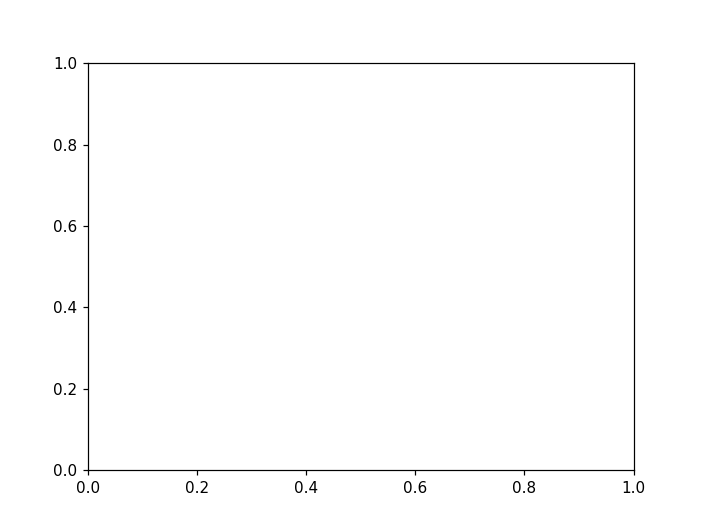

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [14]:
#build live matplotlib fig
fig = plt.figure()

ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

    
for e in range(epochs):
    out = []
    
    for b in range(-10- enc_seq_len, 10 - enc_seq_len):
        optimizer.zero_grad()
        X, Y = get_data(batch_size, enc_seq_len, output_sequence_length)
        
        #Forward pass and calculate loss
        net_out = t(X)
        #print(net_out.shape,Y.shape)
        loss = torch.mean((net_out - Y) ** 2)

        #backwards pass
        loss.backward()
        optimizer.step()

        #Track losses and draw rgaph
        out.append([net_out.detach().numpy(), Y])
        losses.append(loss)

        ax.clear()
        ax.plot(losses)
        ax.set_title("Mean Squared Error")
        fig.canvas.draw()


In [ ]:
####################################################

# Encoder input layer

In [3]:
self.encoder_input_layer = nn.Linear(
  in_features=input_size, 
  out_features=dim_val
)

NameError: name 'input_size' is not defined

# Position Encoder

In [2]:
class PositionalEncoder(nn.Module):
    """
    Adapted from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    https://github.com/LiamMaclean216/Pytorch-Transfomer/blob/master/utils.py 
    """

    def __init__(self, dropout: float = 0.1, max_seq_len: int = 5000, d_model: int = 512):

        """
        Args:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        # Create constant positional encoding matrix with values 
        # dependent on position and i
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        exp_input = torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        
        div_term = torch.exp(exp_input) # Returns a new tensor with the exponential of the elements of exp_input
        
        pe = torch.zeros(max_seq_len, d_model)

        pe[:, 0::2] = torch.sin(position * div_term)
        
        pe[:, 1::2] = torch.cos(position * div_term) # torch.Size([target_seq_len, dim_val])

        pe = pe.unsqueeze(0).transpose(0, 1) # torch.Size([target_seq_len, input_size, dim_val])

        # register that pe is not a model parameter
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val]
        """

        add = self.pe[:x.size(1), :].squeeze(1)

        x = x + add

        return self.dropout(x)

In [ ]:
import positional_encoder as pe

# Create positional encoder
self.positional_encoding_layer = pe.PositionalEncoder(
    d_model=dim_val,
    dropout=dropout_pos_enc,
    max_seq_len=max_seq_len
    )

# Encoder

In [ ]:
# Create an encoder layer
encoder_layer = nn.TransformerEncoderLayer(
    d_model=dim_val,
    nhead=n_heads, 
    batch_first=True
    )

# Stack the encoder layer n times in nn.TransformerDecoder
self.encoder = nn.TransformerEncoder(
    encoder_layer=encoder_layer,
    num_layers=n_encoder_layers, 
    norm=None
)

# Decoder input layer

In [ ]:
self.decoder_input_layer = nn.Linear(
  in_features=input_size, 
  out_features=dim_val
) 

# Decoder

In [ ]:
# Create the decoder layer
decoder_layer = nn.TransformerDecoderLayer(
  d_model=dim_val, 
  nhead=n_heads,
  batch_first=True
  )

# Stack the decoder layer n times
self.decoder = nn.TransformerDecoder(
  decoder_layer=decoder_layer,
  num_layers=n_decoder_layers, 
  norm=None
  )

# Linear output

In [ ]:
self.linear_mapping = nn.Linear(
  in_features=out_seq_len*dim_val,
  out_features=out_seq_len
  )

# combination

In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        max_seq_len: int,
        out_seq_len: int=58,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.2,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            max_seq_len: int, length of the longest sequence the model will 
                         receive. Used in positional encoding. 
            out_seq_len: int, the length of the model's output (i.e. the target
                         sequence length)
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_decoder_layers: int, number of stacked encoder layers in the decoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_decoder: float, the dropout rate of the decoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder
            dim_feedforward_decoder: int, number of neurons in the linear layer 
                                     of the decoder
        """

        super().__init__() 

        self.dec_seq_len = dec_seq_len

        print("input_size is: {}".format(input_size))
        print("dim_val is: {}".format(dim_val))

        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )

        self.decoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )  

        self.linear_mapping = nn.Linear(
            in_features=out_seq_len*dim_val,
            out_features=out_seq_len
            )

        # Create positional encoder
        self.positional_encoding_layer = pe.PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc,
            max_seq_len=max_seq_len
            )

        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=True
            )

        # Stack the encoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerEncoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=True
            )

        # Stack the decoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerDecoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        """
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the feature number
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, E is the feature number.
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """

        # Pass throguh the input layer right before the encoder
        src1 = self.encoder_input_layer(src1)
        src2 = self.encoder_input_layer(src2)
        src3 = self.encoder_input_layer(src3)

        # Pass through the positional encoding layer
        src1 = self.positional_encoding_layer(src1)
        src2 = self.positional_encoding_layer(src2)
        src3 = self.positional_encoding_layer(src3)

        # Pass through all the stacked encoder layers in the encoder
        # Masking is only needed in the encoder if input sequences are padded
        # which they are not in this time series use case, because all my
        # input sequences are naturally of the same length. 
        # (https://github.com/huggingface/transformers/issues/4083)
        src1 = self.encoder(src=src1)
        src2 = self.encoder(src=src2)
        src3 = self.encoder(src=src3)
        src = torch.concat(src1 , src2 , src3)
        

        # Pass decoder input through decoder input layer
        decoder_output = self.decoder_input_layer(tgt)

        # Pass throguh decoder
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
            )

        # Pass through the linear mapping layer
        decoder_output= self.linear_mapping(decoder_output.flatten(start_dim=1))

        return decoder_output